<a href="https://colab.research.google.com/github/Prabhakarrayal/medical-image-denoising-ml/blob/main/Major_Project_Analysis_of_filters_for_medical_image_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
import pandas as pd
import os
from keras.preprocessing import image
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from math import log10,sqrt

In [ ]:
!pip install PyWavelets


In [ ]:

import kagglehub
path = kagglehub.dataset_download("plameneduardo/sarscov2-ctscan-dataset")
print("Path to dataset files:", path)

100%|██████████| 230M/230M [00:06<00:00, 39.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/plameneduardo/sarscov2-ctscan-dataset/versions/2


In [ ]:
path = kagglehub.dataset_download("plameneduardo/sarscov2-ctscan-dataset")
print("Path to dataset files:", path)


In [ ]:
import os
train_images = sorted(os.listdir(os.path.join(path, 'COVID')))


In [ ]:
print("Contents of dataset folder:", os.listdir(path))



In [ ]:
import os
path = '/root/.cache/kagglehub/datasets/plameneduardo/sarscov2-ctscan-dataset/versions/2'
dataset_files = os.listdir(path)
print("Dataset contents:", dataset_files)


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

train_image = [] #Creates an empty list train_image to store the processed images.
train_images = os.listdir(os.path.join(path, 'COVID'))  #Fetches the names of all image files in the 'COVID' directory.
# Change to 'non-COVID' for the other set

for im in train_images:
    img = image.load_img(os.path.join(path, 'COVID', im), target_size=(64, 64), color_mode='grayscale')
    img = image.img_to_array(img)
    img = img / 255  # Normalize the image
    train_image.append(img)

train_df = np.array(train_image)
print(f"Shape of the processed dataset: {train_df.shape}")


In [ ]:
train_images = sorted(os.listdir('/root/.cache/kagglehub/datasets/plameneduardo/sarscov2-ctscan-dataset/versions/2/COVID'))


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import os

train_image = []
train_images = sorted(os.listdir('/root/.cache/kagglehub/datasets/plameneduardo/sarscov2-ctscan-dataset/versions/2/COVID'))

for im in train_images:
    img = image.load_img(os.path.join('/root/.cache/kagglehub/datasets/plameneduardo/sarscov2-ctscan-dataset/versions/2/COVID', im), target_size=(64, 64), color_mode='grayscale')
    img = image.img_to_array(img)
    img = img / 255  # Normalize the image
    train_image.append(img)

train_df = np.array(train_image)
print(f"Shape of the processed dataset: {train_df.shape}")


Length of dataset: 1252
Displaying image 0
Displaying image 1
Displaying image 2
Displaying image 3
Displaying image 4


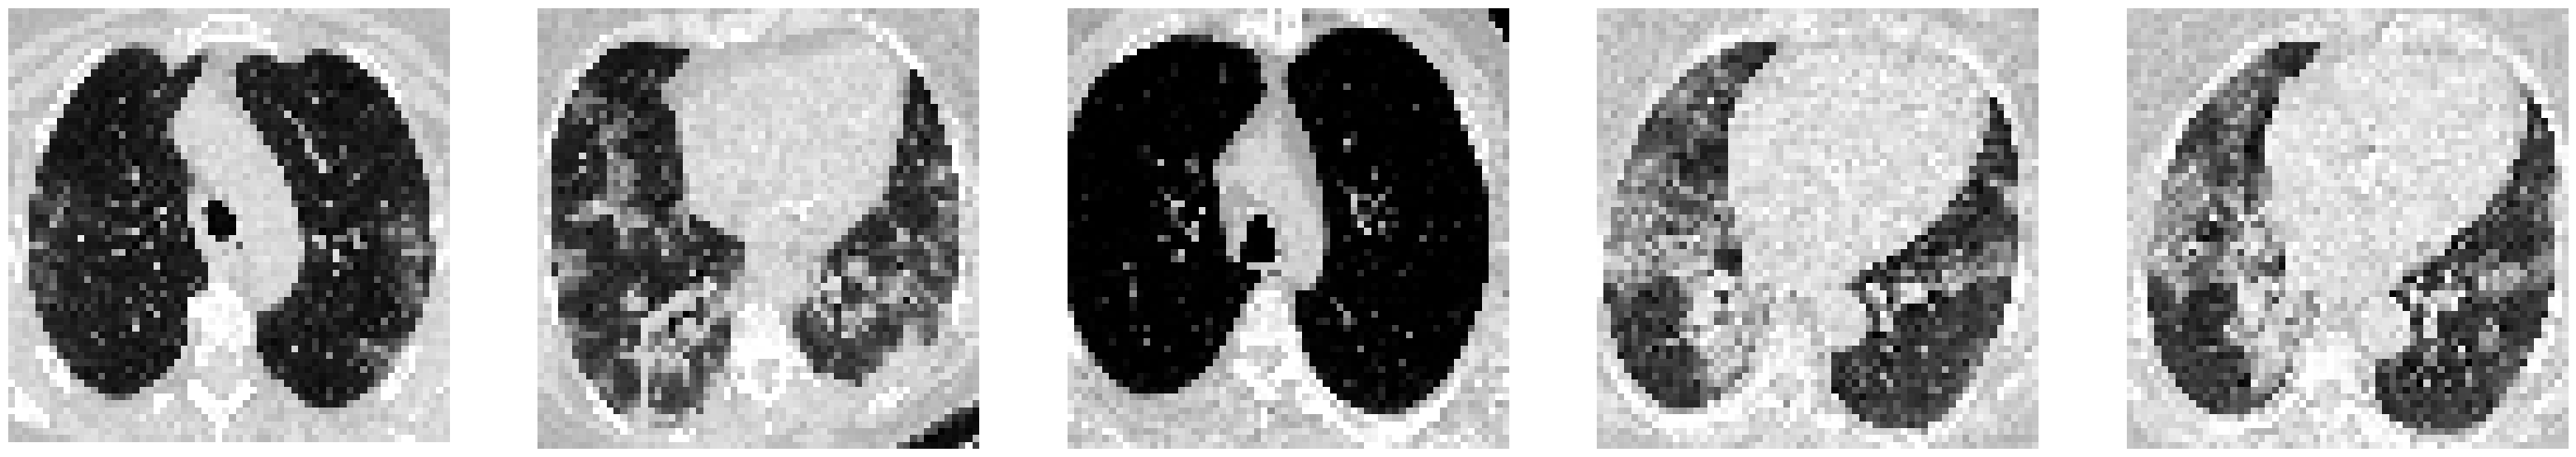

In [ ]:
def plot_img(dataset):
    # Check if dataset has enough images
    print(f"Length of dataset: {len(dataset)}")  # Print length to check
    if len(dataset) < 10:
        print("Dataset does not have enough images. Adjusting to available size.")

    # Create the plot
    f, ax = plt.subplots(1, 5, figsize=(20, 10))  # Adjust figure size to make it more visible
    f.set_size_inches(40, 20)

    # Plot a subset of images
    for i in range(min(5, len(dataset))):  # Avoid IndexError if dataset is smaller
        print(f"Displaying image {i}")
        ax[i].imshow(dataset[i].reshape(64, 64), cmap='gray')  # Display image
        ax[i].axis('off')  # Turn off axis for better clarity
    plt.show()

# Example of calling the function with train_df
plot_img(train_df)



In [ ]:
#Adding gaussian noise with 0.05 factor
def add_noise(image):
  row,col,ch=image.shape
  mean=0
  sigma=1
  gauss=np.random.normal(mean,sigma,(row,col,ch))
  gauss=gauss.reshape(row,col,ch)
  noisy=image+gauss*0.05
  return noisy


In [ ]:
noised_df=[]
for img in train_df:
  noisy=add_noise(img)
  noised_df.append(noisy)

noised_df=np.array(noised_df)


Length of dataset: 1252
Displaying image 0
Displaying image 1
Displaying image 2
Displaying image 3
Displaying image 4


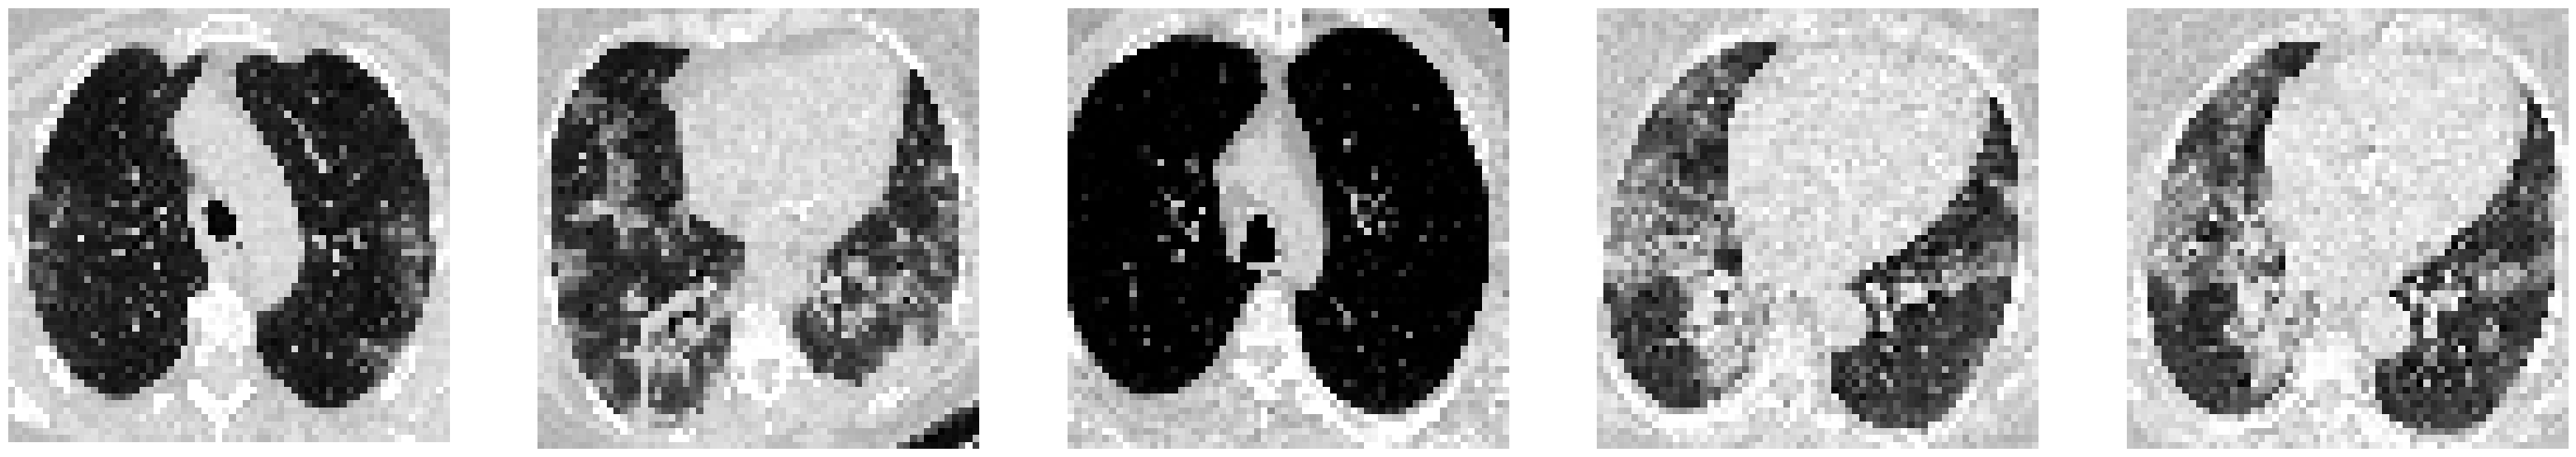

In [ ]:
plot_img(train_df)

Length of dataset: 1252
Displaying image 0
Displaying image 1
Displaying image 2
Displaying image 3
Displaying image 4


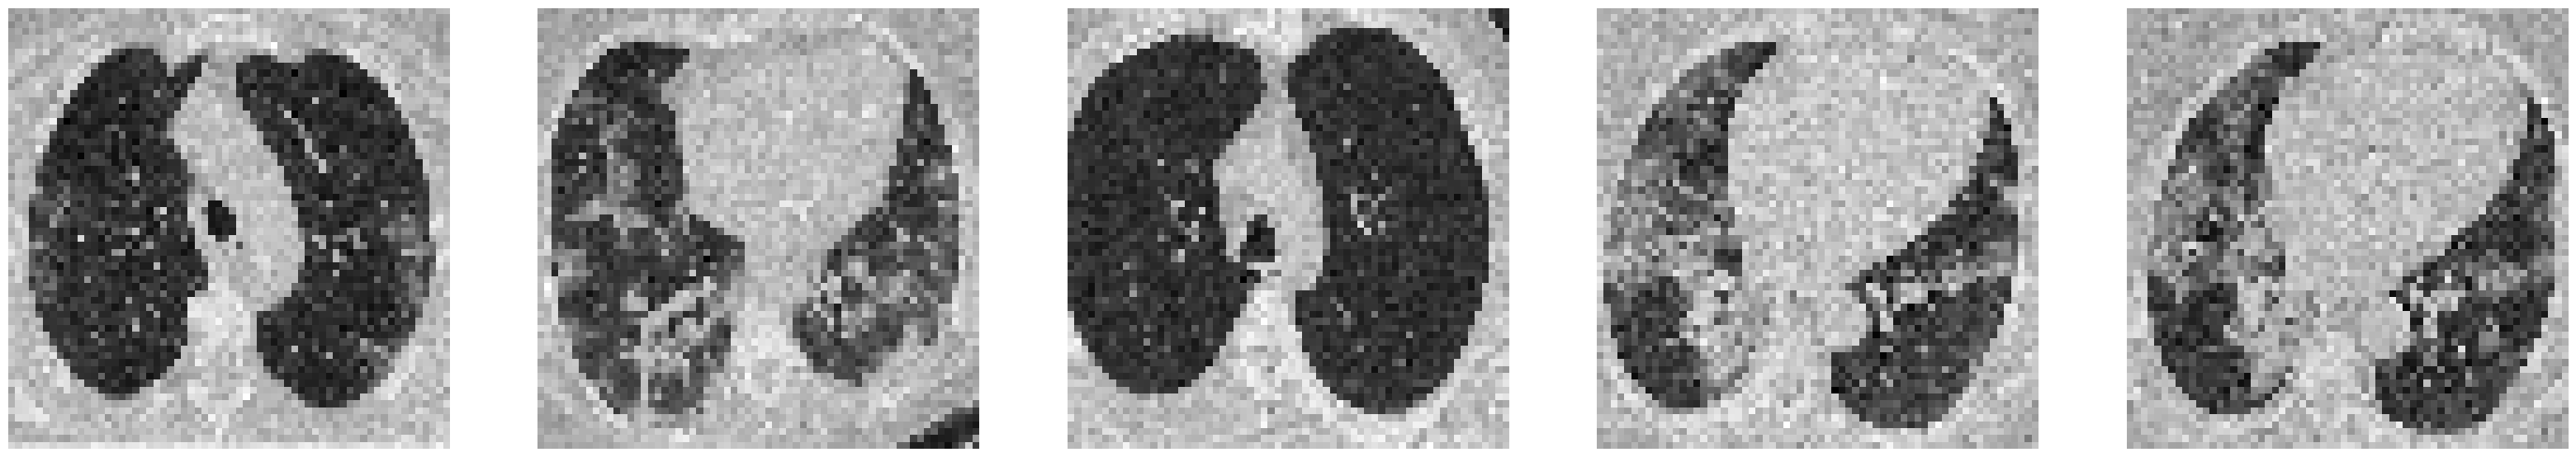

In [ ]:
plot_img(noised_df)

In [ ]:

xnoised=noised_df[:400]
xtest=noised_df[400:]


In [ ]:
def autoencoder():
  input_img=Input(shape=(64,64,1),name='image_input')
  #enoder
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
  x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
  x = MaxPooling2D((2,2), padding='same', name='pool2')(x)

  #decoder
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
  x = UpSampling2D((2,2), name='upsample1')(x)
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv4')(x)
  x = UpSampling2D((2,2), name='upsample2')(x)
  x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)

  #model
  autoencoder = Model(inputs=input_img, outputs=x)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

  return autoencoder

In [ ]:
model= autoencoder()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsample1 (UpSampling2D)        │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsample2 (UpSampling2D)        │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv5 (Conv2D)                  │ (None, 64, 64, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,001 (437.50 KB)

 Trainable params: 112,001 (437.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    model.fit(xnoised, xnoised, epochs=18, batch_size=10, validation_data=(xtest, xtest), callbacks=[early_stopping])

In [ ]:
xtrain= train_df[100:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


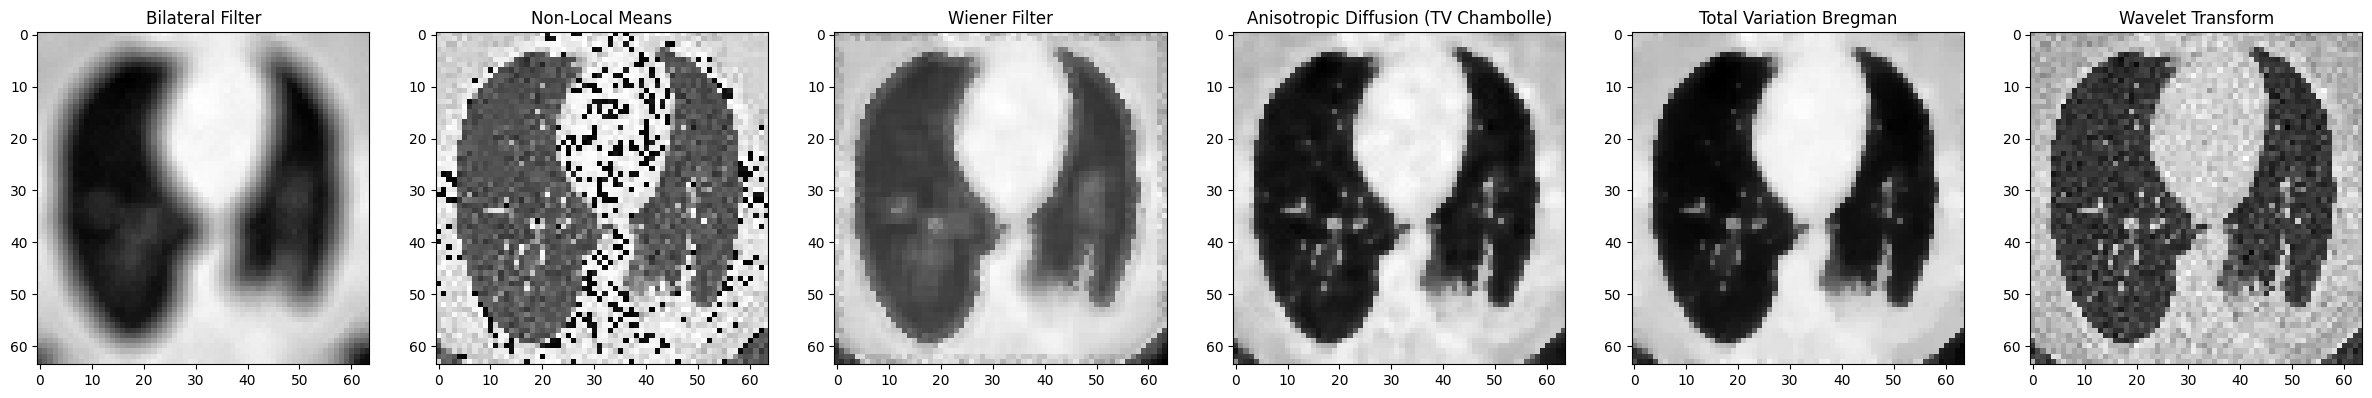

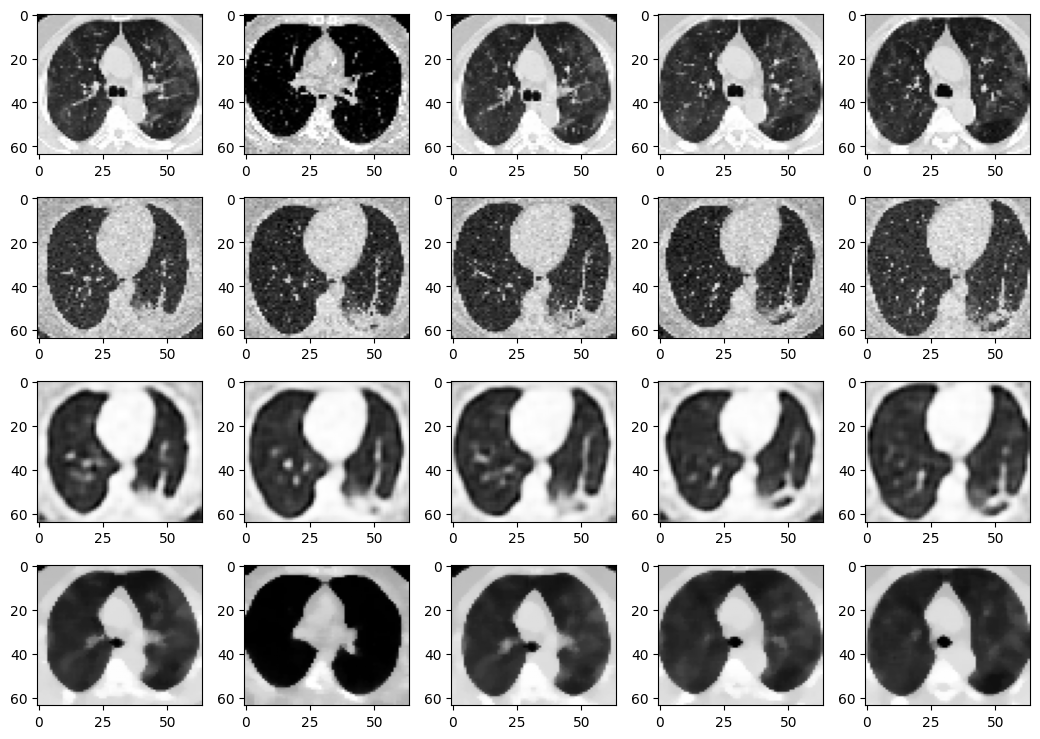

In [ ]:

pred= model.predict(xtest[:5])
import cv2
import numpy as np
from scipy.signal import wiener
from skimage.restoration import denoise_tv_chambolle, denoise_tv_bregman
import pywt

def apply_filters(image):
    """ Apply various denoising filters to an image """

    image = image.astype(np.float32)  # Convert image to float32

    # Gaussian Filter (You can change the kernel size if needed)
    gaussian_filtered = cv2.GaussianBlur(image, (5, 5), 0)


    # Bilateral Filter
    bilateral = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

    # Non-Local Means Filter (Needs uint8 input, so scale up and then normalize back)
    nlm = cv2.fastNlMeansDenoising((image * 255).astype(np.uint8), None, h=10, templateWindowSize=7, searchWindowSize=21) / 255.0

    # Wiener Filter (Ensure image is 2D)
    wiener_filtered = wiener(image.squeeze(), (5, 5))

    # Anisotropic Diffusion (Total Variation Denoising - Chambolle)
    tv_chambolle = denoise_tv_chambolle(image.squeeze(), weight=0.1)

    # Total Variation Bregman Denoising
    tv_bregman = denoise_tv_bregman(image.squeeze(), weight=5)

    # Wavelet Denoising
    coeffs2 = pywt.dwt2(image.squeeze(), 'haar')
    wavelet = pywt.idwt2(coeffs2, 'haar')

    return bilateral, nlm, wiener_filtered, tv_chambolle, tv_bregman, wavelet



# Apply filters to the first test image
bilateral, nlm, wiener_filtered, tv_chambolle, tv_bregman, wavelet = apply_filters(xtest[0])

# Plot comparison
f, ax = plt.subplots(1, 6, figsize=(30, 5))
ax[0].imshow(bilateral, cmap='gray')
ax[0].set_title("Bilateral Filter")

ax[1].imshow(nlm, cmap='gray')
ax[1].set_title("Non-Local Means")

ax[2].imshow(wiener_filtered, cmap='gray')
ax[2].set_title("Wiener Filter")

ax[3].imshow(tv_chambolle, cmap='gray')
ax[3].set_title("Anisotropic Diffusion (TV Chambolle)")

ax[4].imshow(tv_bregman, cmap='gray')
ax[4].set_title("Total Variation Bregman")

ax[5].imshow(wavelet, cmap='gray')
ax[5].set_title("Wavelet Transform")

plt.show()

def plot_predictions(y_true, y_pred):
    f, ax = plt.subplots(4, 5)
    f.set_size_inches(10.5,7.5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(xtrain[i], (64,64)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(y_true[i], (64,64)), aspect='auto', cmap='gray')
        ax[2][i].imshow(np.reshape(y_pred[i], (64,64)), aspect='auto', cmap='gray')
        ax[3][i].imshow(cv2.medianBlur(xtrain[i], (5)), aspect='auto', cmap='gray')
    plt.tight_layout()
plot_predictions(xtest[:5], pred[:5])

Text(0.5, 1.0, 'Gaussian Filter')

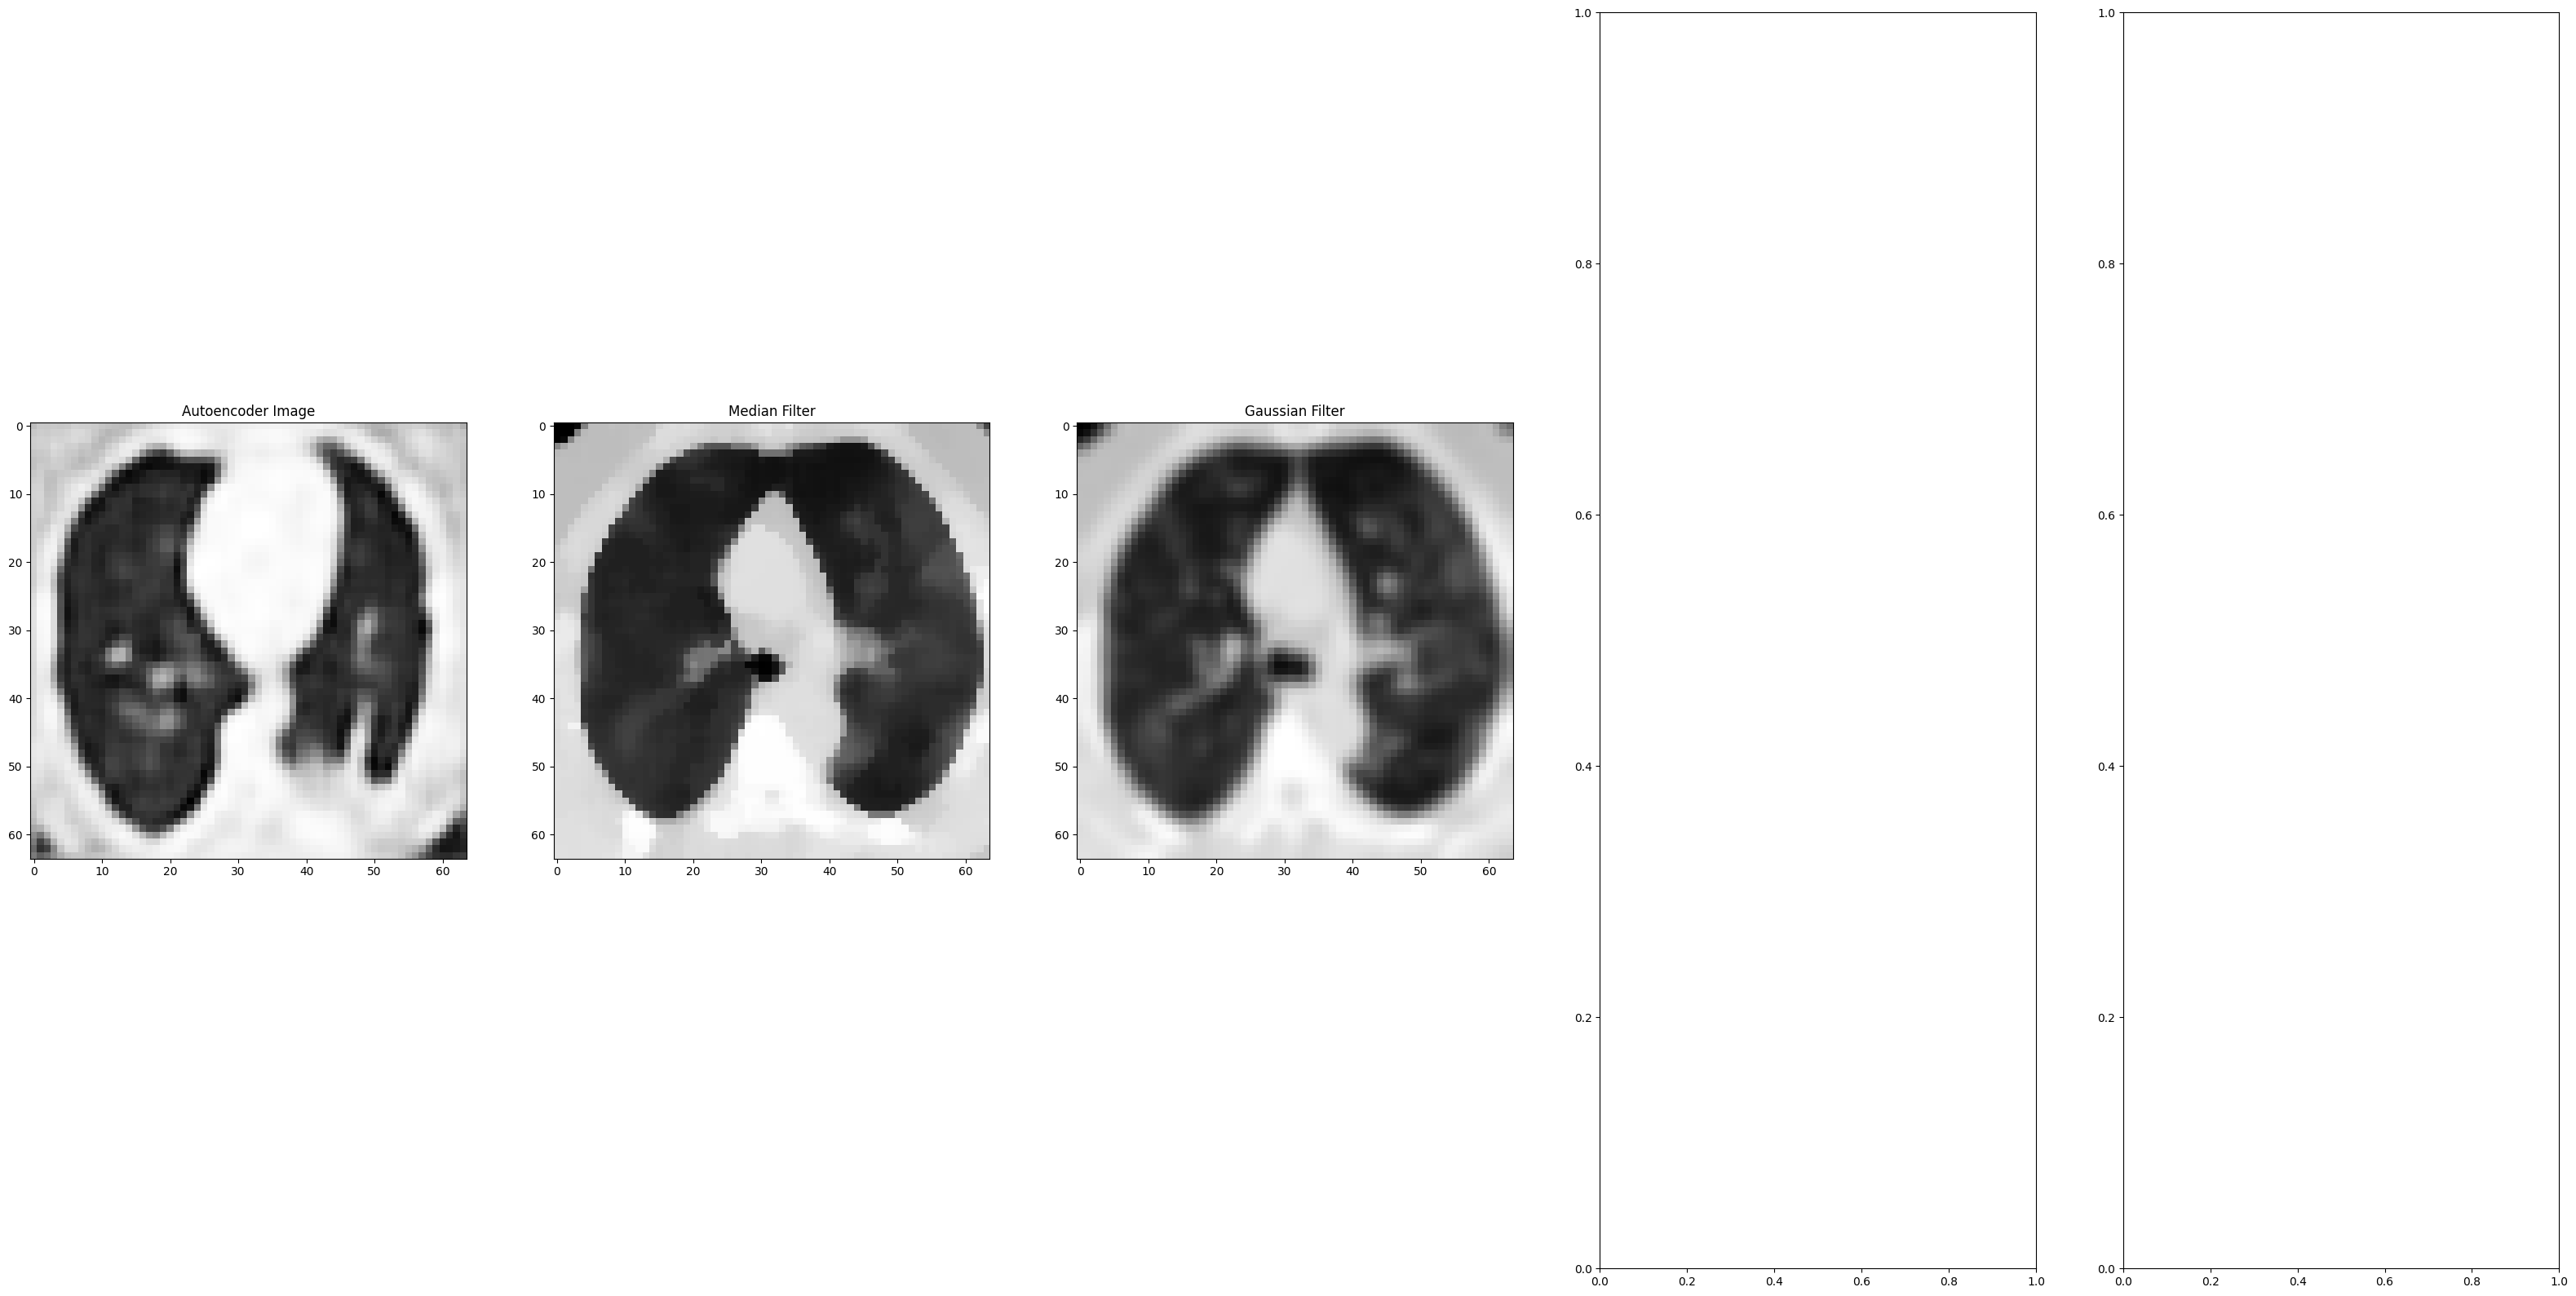

In [ ]:
median_blur = cv2.medianBlur(xtrain[0], (5))
gaussian_blur=cv2.GaussianBlur(xtrain[0],(5,5),0)

f,ax=plt.subplots(1,5)
f.set_size_inches(40,20)
ax[0].imshow(pred[0].reshape(64,64), cmap='gray')
ax[0].set_title('Autoencoder Image')
ax[1].imshow(median_blur,cmap='gray')
ax[1].set_title('Median Filter')
ax[2].imshow(gaussian_blur,cmap='gray')
ax[2].set_title('Gaussian Filter')


In [ ]:
def PSNR(original, denoised):
    original = original * 255.0
    denoised = denoised * 255.0
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr



psnr_autoencoder = PSNR(xtest[0], pred[0])  # PSNR between original and autoencoder image
psnr_median_blur = PSNR(xtest[0], median_blur)  # PSNR between original and median blur
psnr_gaussian_blur = PSNR(xtest[0], gaussian_blur)  # PSNR between original and gaussian blur
psnr_bilateral = PSNR(xtest[0], bilateral)
psnr_nlm = PSNR(xtest[0], nlm)
psnr_wiener = PSNR(xtest[0], wiener_filtered)
psnr_tv_chambolle = PSNR(xtest[0], tv_chambolle)
psnr_tv_bregman = PSNR(xtest[0], tv_bregman)
psnr_wavelet = PSNR(xtest[0], wavelet)

print(f"Autoencoder Image: {psnr_autoencoder:.2f} dB")
print(f"Median Filter: {psnr_median_blur:.2f} dB")
print(f"Gaussian Filter: {psnr_gaussian_blur:.2f} dB")
print("\nAdditional PSNR values:\n")
print(f"Bilateral Filter: {psnr_bilateral:.2f} dB")
print(f"Non-Local Means: {psnr_nlm:.2f} dB")
print(f"Wiener Filter: {psnr_wiener:.2f} dB")
print(f"Anisotropic Diffusion: {psnr_tv_chambolle:.2f} dB")
print(f"Total Variation Bregman: {psnr_tv_bregman:.2f} dB")
print(f"Wavelet Transform: {psnr_wavelet:.2f} dB")


Autoencoder Image: 19.92 dB
Median Filter: 8.62 dB
Gaussian Filter: 8.91 dB

Additional PSNR values:

Bilateral Filter: 8.56 dB
Non-Local Means: 7.14 dB
Wiener Filter: 8.22 dB
Anisotropic Diffusion: 7.98 dB
Total Variation Bregman: 8.15 dB
Wavelet Transform: 7.62 dB


In [ ]:
# After training your autoencoder, save predictions on test data
import numpy as np

# Assuming xtest is your noisy test data
autoencoder_predictions = model.predict(xtest)
np.save('autoencoder_predictions.npy', autoencoder_predictions)


In [ ]:
def dncnn_model():
    input_img = Input(shape=(64, 64, 1))
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_img)
    for _ in range(15):
        x = Conv2D(64, (3, 3), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
    x = Conv2D(1, (3, 3), padding='same')(x)
    x = tf.keras.layers.subtract([input_img, x])  # Residual Learning
    model = Model(inputs=input_img, outputs=x)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
dncnn = dncnn_model()
dncnn.summary()
dncnn.fit(xnoised, xnoised, epochs=10, batch_size=10, validation_data=(xtest, xtest))
dncnn_pred = dncnn.predict(xtest[:5])
dncnn = dncnn_model()
dncnn.summary()
dncnn.fit(xnoised, xnoised, epochs=10, batch_size=10, validation_data=(xtest, xtest))
dncnn_pred = dncnn.predict(xtest[:5])
def noise2noise_model():
    input_img = Input(shape=(64, 64, 1))
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(inputs=input_img, outputs=x)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

noise2noise = noise2noise_model()
noise2noise.summary()

# Training: noisy -> noisy
noise2noise.fit(xnoised, train_df[:400], epochs=10, batch_size=10, validation_data=(xtest, train_df[400:]))

# Prediction
noise2noise_pred = noise2noise.predict(xtest[:5])
psnr_dncnn = PSNR(xtest[0], dncnn_pred[0])
psnr_noise2noise = PSNR(xtest[0], noise2noise_pred[0])

print(f"DnCNN PSNR: {psnr_dncnn:.2f} dB")
print(f"Noise2Noise PSNR: {psnr_noise2noise:.2f} dB")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 558,977 (2.13 MB)

 Trainable params: 557,057 (2.13 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 270s 6s/step - loss: 0.4476 - val_loss: 0.0982
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 313s 8s/step - loss: 0.0015 - val_loss: 0.0035
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 306s 8s/step - loss: 6.4590e-04 - val_loss: 6.2322e-04
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 249s 6s/step - loss: 4.8461e-04 - val_loss: 5.2752e-04
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 319s 8s/step - loss: 3.9786e-04 - val_loss: 5.4095e-04
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 265s 6s/step - loss: 2.9563e-04 - val_loss: 5.2284e-04
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 318s 8s/step - loss: 3.1003e-04 - val_loss: 4.7338e-04
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 306s 8s/step - loss: 2.0920e-04 - val_loss: 3.3367e-04
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 305s 8s/step - loss: 2.2701e-04 - val_loss: 1.6539e-04
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 322s 8s/step - loss: 1.8602e-04 - val_loss: 2.5193e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_17[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │     36,928 │ activation_15[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │     36,928 │ activation_16[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     36,928 │ activation_17[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │     36,928 │ activation_18[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 558,977 (2.13 MB)

 Trainable params: 557,057 (2.13 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 264s 6s/step - loss: 0.2491 - val_loss: 0.0055
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 321s 8s/step - loss: 3.0990e-04 - val_loss: 0.0027
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 320s 8s/step - loss: 9.6242e-05 - val_loss: 0.0015
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 322s 8s/step - loss: 6.4512e-05 - val_loss: 7.5436e-04
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 323s 8s/step - loss: 4.2826e-05 - val_loss: 3.6750e-04
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 319s 8s/step - loss: 3.2886e-05 - val_loss: 1.8481e-04
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 323s 8s/step - loss: 3.2468e-05 - val_loss: 9.8449e-05
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 2.6240e-05